In [1]:
import pandas as pd
alerts_df = pd.read_csv('Data/alerts.csv')
alerts_df.head()



,Alert ID,User ID,Title,Entry Date Time,Event Date Time,Description,Latitude,Longitude,City,Num Affirmatives,Num Responds,Cluster,P_True_random_forest
0,d6114146-192e-410a-9513-2c9c71736832,8cf9ef37-5c0f-4d8b-aa89-44bbe26e5ac0,Assault in busy market,2025-01-27 17:14:45.468211,2025-01-05 12:53:04.960805,A resident reported an attempted break-in thro...,30.037186,31.221344,Cairo,3,19,0,0.383484
1,da87c183-aef2-4ed2-8623-056b34d071fe,a8e3aa27-1829-4aeb-aef7-b0b283a97f75,Illegal drug activity,2025-01-25 13:22:07.854068,2024-09-30 21:22:38.399233,A resident reported an attempted break-in thro...,30.062123,31.257263,Cairo,31,35,1,0.827798
2,e364c45e-08a5-4d91-b8d3-1e0fc8f93696,f5698696-3c64-4b3a-8eec-b528b293f9b8,Home burglary attempt,2025-01-29 15:39:06.166261,2025-01-18 00:28:29.560473,Eyewitness reports seeing a person breaking in...,30.059548,31.212546,Cairo,50,50,2,0.849962
3,cf55cf93-68f8-4eee-a4fb-fd6deacabd16,e0ace32f-0368-44c2-8998-132dcd84cfce,Home burglary attempt,2025-01-22 17:03:13.394264,2024-09-24 01:26:08.955150,A fraudulent transaction was detected at a maj...,30.058783,31.217377,Cairo,39,44,3,0.842014
4,5152ca9b-d2fb-4b8e-ad38-bc24105e9258,32e364c5-b4cd-4ebb-8d8b-38646ce65812,ATM skimming device found,2025-01-24 18:48:03.441404,2025-01-01 00:43:05.145341,Family members report a missing individual las...,30.054465,31.251026,Cairo,6,11,1,0.625938


# User Rating Calculation

<Axes: title={'center': 'User Credibility Score Distribution'}, ylabel='Frequency'>

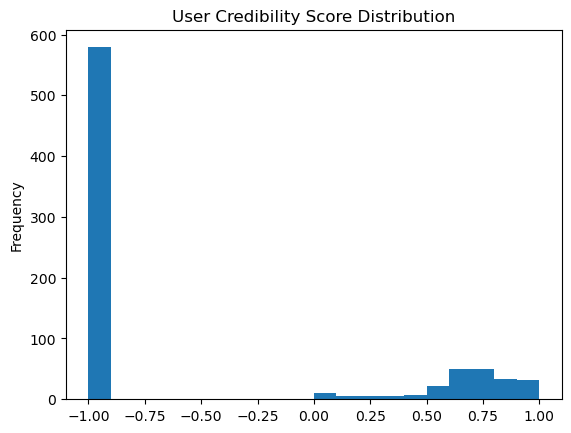

In [2]:
user_df = pd.read_csv('Data/users.csv')

# Compute User Credibility Scores
alerts = alerts_df.groupby("User ID").agg(
    total_affirmatives=("Num Affirmatives", "sum"),
    total_responses=("Num Responds", "sum")
).reset_index()

# Calculate credibility ratio for each user
user_df["User Credibility"] = alerts.apply(
    lambda row: row["total_affirmatives"] / row["total_responses"] if row["total_responses"] > 0 else 0,
    axis=1
)
user_df["User Credibility"]=user_df['User Credibility'].fillna(-1)
user_df.to_csv('Data/users.csv', index=False)
# plot the distribution of user credibility scores
user_df["User Credibility"].plot.hist(bins=20, title="User Credibility Score Distribution")

# Clustering

In [3]:
# now lets cluster the data
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic


def vincenty_distance(point_a, point_b):
    # geodesic() uses the WGS-84 ellipsoid by default (Vincenty calculations).
    return geodesic(point_a, point_b).kilometers



# Create a clustering model
dbscan = DBSCAN(eps=0.3, 
                min_samples=1, 
                metric=vincenty_distance,
)

# Fit the model
clusters = dbscan.fit_predict(alerts_df[['Latitude', 'Longitude']])
alerts_df['Cluster'] = clusters
alerts_df['Cluster'].value_counts()


Cluster
1     39
2     28
0     27
14    12
9     10
      ..
50     1
51     1
52     1
53     1
82     1
Name: count, Length: 83, dtype: int64

In [4]:
import folium

marker_colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]


def create_map(df):

    m = folium.Map([df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=13)

    # Loop over the DataFrame rows and add a marker for each incident
    for idx, row in df.iterrows():
        popup_text = (
            f"Title: {row['Title']}<br>"
            f"Timestamp: {row['Event Date Time']}<br>"
            f"Cluster: {row['Cluster']}"
        )
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_text,
            icon=folium.Icon(color=marker_colors[row['Cluster']%len(marker_colors)], icon='info-sign')
        ).add_to(m)

    # Save the map to an HTML file
    m.save('map.html')

create_map(alerts_df)

# Random Forrest Classifier

In [5]:
creds = pd.merge(alerts_df, user_df, on='User ID', how='right')["User Credibility"]
classifer_df = alerts_df[['Entry Date Time', 'Event Date Time', 'Latitude', 'Longitude', 'Cluster']]
classifer_df['User Credibility'] = creds
classifer_df['Time Difference'] = (pd.to_datetime(classifer_df['Entry Date Time']) - pd.to_datetime(classifer_df['Event Date Time'])).dt.total_seconds()
classifer_df.drop(columns=['Entry Date Time', 'Event Date Time'], inplace=True)

Y_true = alerts_df['Num Affirmatives'] / alerts_df['Num Responds']

classifer_df.head()

/var/folders/26/gpxb1mwx5zd590_4yvmsyt0m0000gn/T/ipykernel_14833/3393208109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifer_df['User Credibility'] = creds
/var/folders/26/gpxb1mwx5zd590_4yvmsyt0m0000gn/T/ipykernel_14833/3393208109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifer_df['Time Difference'] = (pd.to_datetime(classifer_df['Entry Date Time']) - pd.to_datetime(classifer_df['Event Date Time'])).dt.total_seconds()
/var/folders/26/gpxb1mwx5zd590_4yvmsyt0m0000gn/T/ipykernel_148

,Latitude,Longitude,Cluster,User Credibility,Time Difference
0,30.037186,31.221344,0,0.736842,1.916501e+06
1,30.062123,31.257263,1,0.956522,1.007997e+07
2,30.059548,31.212546,2,0.851064,1.005037e+06
3,30.058783,31.217377,3,0.766990,1.042422e+07
4,30.054465,31.251026,1,0.384615,2.052298e+06


In [6]:
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(classifer_df[['Latitude', 'Longitude', 'User Credibility']], Y_true)

Y_pred = rf.predict(classifer_df[['Latitude', 'Longitude', 'User Credibility']])

from sklearn.metrics import mean_squared_error

mean_squared_error(Y_true, Y_pred)


0.008717428856010546

In [7]:
alerts_df.head()

,Alert ID,User ID,Title,Entry Date Time,Event Date Time,Description,Latitude,Longitude,City,Num Affirmatives,Num Responds,Cluster,P_True_random_forest
0,d6114146-192e-410a-9513-2c9c71736832,8cf9ef37-5c0f-4d8b-aa89-44bbe26e5ac0,Assault in busy market,2025-01-27 17:14:45.468211,2025-01-05 12:53:04.960805,A resident reported an attempted break-in thro...,30.037186,31.221344,Cairo,3,19,0,0.383484
1,da87c183-aef2-4ed2-8623-056b34d071fe,a8e3aa27-1829-4aeb-aef7-b0b283a97f75,Illegal drug activity,2025-01-25 13:22:07.854068,2024-09-30 21:22:38.399233,A resident reported an attempted break-in thro...,30.062123,31.257263,Cairo,31,35,1,0.827798
2,e364c45e-08a5-4d91-b8d3-1e0fc8f93696,f5698696-3c64-4b3a-8eec-b528b293f9b8,Home burglary attempt,2025-01-29 15:39:06.166261,2025-01-18 00:28:29.560473,Eyewitness reports seeing a person breaking in...,30.059548,31.212546,Cairo,50,50,2,0.849962
3,cf55cf93-68f8-4eee-a4fb-fd6deacabd16,e0ace32f-0368-44c2-8998-132dcd84cfce,Home burglary attempt,2025-01-22 17:03:13.394264,2024-09-24 01:26:08.955150,A fraudulent transaction was detected at a maj...,30.058783,31.217377,Cairo,39,44,3,0.842014
4,5152ca9b-d2fb-4b8e-ad38-bc24105e9258,32e364c5-b4cd-4ebb-8d8b-38646ce65812,ATM skimming device found,2025-01-24 18:48:03.441404,2025-01-01 00:43:05.145341,Family members report a missing individual las...,30.054465,31.251026,Cairo,6,11,1,0.625938


In [8]:
alerts_df['P_True_random_forest'] = Y_pred
alerts_df.to_csv('Data/alerts.csv', index=False)